# Лабораторная работа №1
### Жерлыгин Максим


## Задание

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$ .

### Вариант 7
Начально-краевая задача для дифференциального уравнения параболического типа.
$$\begin{align*} &\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + 0.5\exp(-0.5t)\sin x,\\
&u_x(0,t) = \exp(-0.5t),\\
&u_x(\pi,t) = -\exp(-0.5t),\\
&u(x,0) = \sin x,\end{align*}$$


Аналитическое решение $U(x,t) = \exp(-0.5t)\sin x.$

## Подготовительная часть


In [1]:
#@title Additions
# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [2]:
import math
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
co = 0

In [3]:

def f_1(x,t):
    return 0.5*math.exp(-0.5*t)*math.cos(x)
def f_2(x,t):
    return math.exp(-0.5*t)
def f_3(x,t):
    return -math.exp(-0.5*t)
def f_4(x,t = None):
    return math.sin(x)
def analytic(x,t):
    return math.exp(-0.5*t)*math.sin(x)
        
def MAE(x,t,u):
    error = 0
    for x_ in range(len(x)):
        for y_ in range(len(t)):
            error += abs(u[x_][y_] - analytic(x[x_], t[y_]))
    return error/(len(x) * len(t))    

def normm(x,t,u):
    errors = []
    for i in range(len(u)):
        maximum = 0
        for j in range(len(u[0])):
            tmp = abs(u[i][j] - analytic(x[j], t[i]))
            if maximum < tmp:
                maximum = tmp
        errors.append(maximum)
    return errors
def norm_error(x,t,u):
    ans = 0.0
    for i in range(len(u)):
        for j in range(len(u[i])):
            ans += (u[i][j] - analytic(x[i][j], t[i][j]))**2
    return ans/len(u[0])
    
def MSE(X,T,U):
    error = 0
    for x in range(0,len(X)):
        for t in range(0,len(T)):
            error += (U[t][x] - analytic(X[x],T[t]))**2
    return (error/(len(X)*len(T)))/(len(X)*len(T))    

def plot_approximations(u_approx, x):
    approximations = ['2d1', '2d2', '3d2']
    for j in range(len(u_approx)):
        fig = go.Figure()
        fig.update_layout(title = approximations[j][0] + " points " +\
                          approximations[j][-1] + \
                          ("-st order" if approximations[j][-1] == '1' else "-nd order")  +\
                          " approximation",
                         xaxis_title = 'x',
                         yaxis_title = 'U(x,t)')
        for i in range(min(200, len(u_approx[0]))):
            fig.add_trace(go.Scatter(x = x, y = u_approx[j][i], name = 't = ' + str(i)))
        fig.update_layout(template="plotly_dark")
        fig.show()  
        #save_plot(fig)  
        
def time_error(x,u,T):
    error = []
    for t in range(len(T)):
        error_tmp = 0
        for i in range(len(x)):
            error_tmp += (u[t][i] - analytic(x[i],T[t]))**2
        error.append(np.sqrt(error_tmp))
    return error



def different_time_error(method, N, T, approx_type):
  Ks = [100, 200, 500, 1000, 5000]
  h = math.pi/N
  x = np.arange(0, math.pi + h/2 - 1e-4, h)
  taus, errors = [], []
  for K_ in Ks:
    taus.append(T/K_)
    t = np.arange(0, T + taus[-1]/2 - 1e-4, taus[-1])
    u_method = method(N = N, K = K_, T = T, approx_type = approx_type)
    errors.append(math.log(MSE(x,t,u_method)+1e-14))
  return errors, taus


def different_space_error(method, K, T, approx_type):
  Ns = [3, 5, 10, 25, 50, 100]
  tau = T/K
  t = np.arange(0, T + tau - 1e-4, tau)
  hs, errors = [], []
  for N_ in Ns:
    hs.append(math.pi/N_)
    x = np.arange(0, math.pi + hs[-1] - 1e-4, hs[-1])
    u_method = method(N = N_, K = K, T = T, approx_type = approx_type)
    errors.append(math.log(MSE(x,t,u_method) + 1e-14))
  return errors, hs


def plot_different_splits(errors, xs, title, xaxis_title):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x = xs, y = errors))
  fig.update_layout(title = f'Errors with different {title}',
                    template = 'plotly_dark',
                    xaxis_title = xaxis_title,
                    yaxis_title = 'Error (MAE)')
  fig.show()

def save_plot(fig):
  global co
  fig.write_html("plots/plot" + str(co)+".html")
  co += 1
  return "plot " + str(co) + " saved"

def construct_3d_plot(method, method_name, approx_type = '2d2'):
    N_ = 7
    T = 5
    K_ = 1000
    h = math.pi/N_
    x = np.arange(0, math.pi + h, h)
    N = len(x)
    tau = T/K_
    t = np.arange(0, T + tau, tau)
    K = len(t)
    X_e = [x,x]
    T_e = []
    T_e.append([0.0 for _ in x])
    T_e.append([tau for _ in x])
    for k in range(1, K-1):
        X_e.append(x)
        T_e.append([t[k] for _ in x])
    approx_e = method(N_, K_, T, approx_type = approx_type)
    z_plot = []
    for j in range(0, len(X_e), 1):
        tmp = []
        for i in range(0, len(X_e[j]), 1):
            tmp.append(analytic(X_e[j][i], T_e[j][i]))
        z_plot.append(tmp)
    line_marker = dict(color='#0066FF', width=2)
    lines = []
    lines.append(go.Scatter3d(x=X_e[0], y=T_e[0], z=approx_e[0], mode='lines', line=line_marker, name = method_name + ' method', legendgroup=1))
    for i, j, k in zip(X_e[1:], T_e[1:], approx_e[1:]):
        lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    line_marker = dict(color='#ff0000', width=2)
    #my_layout = go.Layout({"title": "Views by publisher", scene = go.Scene(),
    #                       "showlegend": False})
    fig_new = go.Figure(data = lines)
    fig_new.update_layout(template="plotly_dark")
    fig_new.update_scenes(xaxis_title=dict(text = 'x'), yaxis_title = dict(text = 't'), zaxis_title = dict(text = "U(x,t)"))
    fig_new.add_trace(go.Scatter3d(x=X_e[0], y=T_e[0], z=z_plot[0], mode='lines', line=line_marker, name = 'Analytic', legendgroup = 2))
    for i, j, k in zip(X_e[1:], T_e[1:], z_plot[1:]):
        fig_new.add_trace(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    fig_new.show()
    #save_plot(fig_new)

    print("Total error = ", norm_error(X_e, T_e, approx_e))

In [4]:
def plot_error(errors, type):
    global co
    e_tmp = []
    e_x = []
    for e_ in errors:
        e_x.append(len(e_))
        e_tmp.append(sum(e_)/len(e_))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = e_x, y = e_tmp))
    fig.update_layout(title = 'Errors with different ' + str(type),
                     xaxis_title = "splits", 
                     yaxis_title = "Error",
                      template="plotly_dark")
    fig.show()
#    save_plot(fig)

## Аналитическое решение

[К оглавлению](#content)

In [5]:
N = 50
T = 50
K = 70000

In [6]:
def fill(space_step, N, K):
    U = np.zeros([K,N])
    for j in range(N):
        U[0][j] = f_4(j * space_step)
    return U

In [7]:
h = math.pi/N
x = np.arange(0, math.pi + h - 0.0001, h)
tau = T/K
t = np.arange(0, T + tau - 0.0001, tau)
u_a = np.zeros((len(t),len(x)))
approximations = ['2d1', '2d2', '3d2']
if tau/h**2 >= 1/2:
    print("\033[33m {}" .format('Attention!!! Courant condition:'))
    print('sigma > 1/2')
for k in range(len(t)):
    for j in range(len(x)):
        u_a[k][j] = analytic(j * h, k * tau)
fig = go.Figure()
fig.add_trace(go.Scatter(x = x, y = u_a[-2], name = 'Analytical Solution'))
fig.update_layout(title="Analytical Solution",
                  xaxis_title="x",
                  yaxis_title="$U(x,t)$",
                  template="plotly_dark")
fig.show()

for i in range(min(200, len(u_a))):
  fig.add_trace(go.Scatter(x = x, y = u_a[i], name = 't = ' + str(round(t[i],2))))

fig.show()

## Явная конечно-разностная схема


### Теоретическая часть

Два временных слоя: нижний, на котором известно распределение функции (в нашем случае $f_4$ или $\sin x$, и верхний, на котором распределение подлежит определению. Введем сетку и сеточные функции.

Аппроксимируем дифференциальные операторы отношением конечных разностей:
$$\begin{align*}
& u_{t}(x_{j}, t_{k}) = \frac{u_{j}^{k+1}-u_{j}^{k}}{\tau} \\
& u_{xx}(x_j, t_{k}) = \frac{u_{j-1}^{k} -2u_{j}^{k} + u_{j+1}^{k}}{h^2}
\end{align*}$$

Подставим полученные выражения в исходное уравнение:

$$\begin{align*} 
\frac{u_{j}^{k+1}-u_{j}^{k}}{\tau}
 = a\frac{u_{j+1}^{k} -2u_{j}^{k} + u_{j-1}^{k}}{h^2}\end{align*}$$

 Причем $u_{0}^{k} = f_2(t^k)$ или $\varphi_{0}(t^{k}) = \exp(-0.5t)$ и $u_{N}^{k} = f_3(t^k)$ или $\varphi_{l}(t^{k}) = -\exp(-0.5t)$. $u^0_j = \psi(x_j) = f_4$

 Введем обозначение $\sigma = \frac{a\tau}{h^2}$ и выразим из предыдущего уравнения $u_j^{k+1}:$
$$ u_{j}^{k+1} = \sigma u_{j-1}^{k} + (1-2\sigma)u_{j}^{k} + \sigma u_{j+1}^k, \hspace{0.5cm} \sigma = \frac{\tau}{h^2},\hspace{0.2cm} j = \overline{1, N-1}, \hspace{0.2cm} k = 0,1,2,\ldots,$$

Схема обладает существенным изъяном -- она перестает быть условно устойчивой при $\sigma > \frac{1}{2}$ -- условие Куранта. Однако удобством является отсутствие необходимости решения СЛАУ.

### Реализация

In [ ]:
def approxes(method, N = 25, K = 50000, T = 70, a = 1.0):
    approximations = ['2d1', '2d2', '3d2']
    u_approx = []
    for i in tqdm(range(len(approximations))):
        u_approx.append(method(N, K, T, approx_type=approximations[i], a = a))
    return u_approx

In [ ]:
def explicit(N = 25, K = 50000, T = 70, approx_type = '2d1', a = 1.0):
  space_step = math.pi/N
  x = np.arange(0, math.pi + space_step - 0.0001, space_step) 
  time_step = T/K
  t = np.arange(0, T + time_step - 0.0001, time_step)
  sigma = 1 / space_step**2
  if time_step/space_step**2 >= 1/2:
      print("\033[33m {}" .format('Attention!!! Courant condition:'))
      print('sigma > 1/2')
  u = fill(space_step, len(x), len(t))
  for k in range(len(t)-1):
      for j in range(1, len(x)-1):
          u[k+1][j] = u[k][j] + \
             f_1(x[j], t[k]) * time_step  \
             + time_step*sigma*(u[k][j+1] - 2*u[k][j] + u[k][j-1])
      if approx_type == '2d1':
          #двухточечная, первый порядок
          u[k+1][0] = space_step*f_2(None, t[k]) - u[k+1][1]
          u[k+1][-1] = space_step*f_3(None, t[k]) + u[k+1][-2]
      if approx_type == '2d2':
          #двухточечная, второй порядок
          u[k+1][0] = (-u[k+1][1] + space_step * f_2(None, (k+2)*time_step) - (space_step**2 / (2*time_step) * u[k][0])) / (1+space_step**2 / (2*time_step))
          u[k+1][-1] = (u[k+1][-2] + space_step*f_3(None, (k+2)*time_step) + space_step**2 / (2*time_step)*u[k][-1]) / (1+space_step**2/(2*time_step))
      if approx_type == '3d2':
          #трехточечная, второй порядок
          u[k+1][0] = (2*space_step*f_2(None, t[k]) - 4*u[k+1][1] + u[k+1][2]) / -3
          u[k+1][-1] = (2*space_step*f_3(None, t[k]) + 4*u[k+1][-2] - u[k+1][-3]) / -3
  return u

### Исследования

  0%|          | 0/3 [00:00<?, ?it/s]

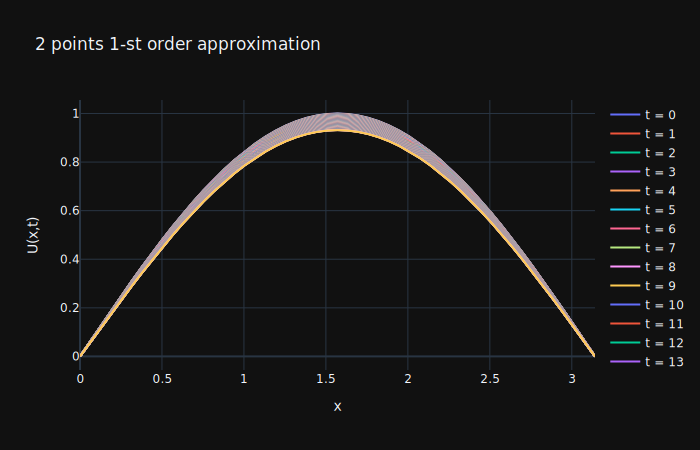

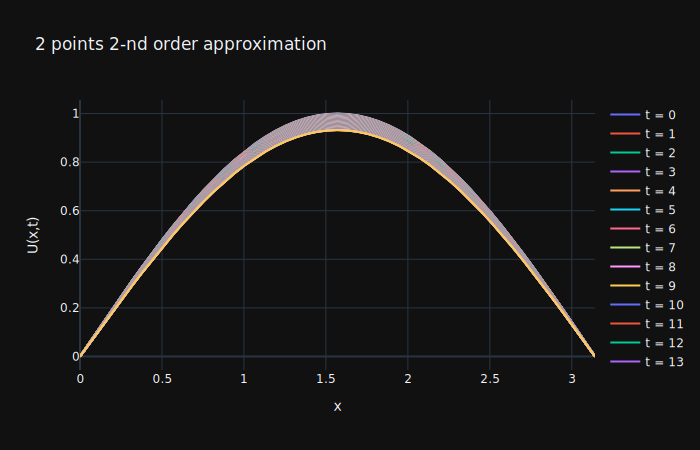

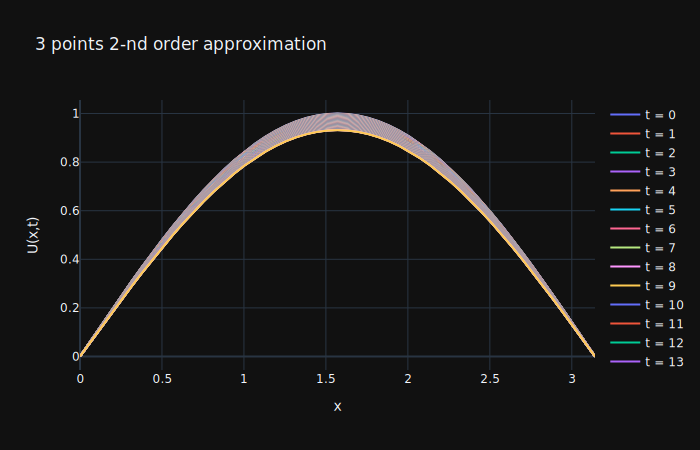

In [ ]:
u_approx = approxes(explicit, N, K, T)
plot_approximations(u_approx, x)

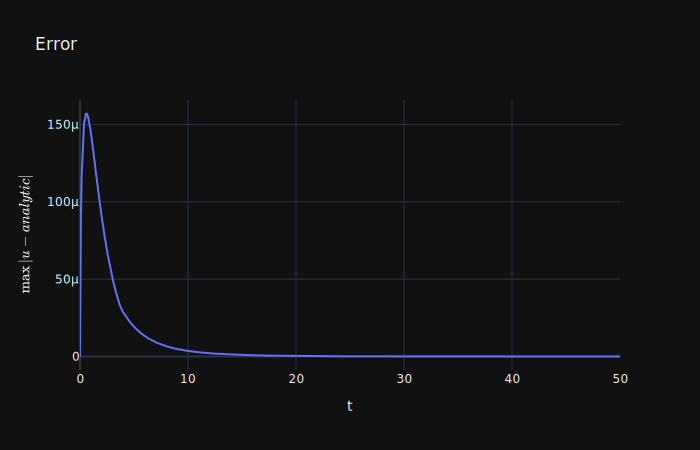

In [ ]:
er = normm(x,t,u_approx[1])
fig_check_tmp = go.Figure()
fig_check_tmp.add_trace(go.Scatter(x = t, y = er))
fig_check_tmp.update_layout(title = "Error",
                            xaxis_title = "t",
                            yaxis_title = r'$\max |u - analytic|$', 
                            template='plotly_dark')
fig_check_tmp.show()
#save_plot(fig_check_tmp)

In [ ]:
[MSE(x, t, u_approx[i]) for i in range(3)]

[3.2049630058506486e-15, 5.2959164704360815e-17, 9.800720760941467e-15]

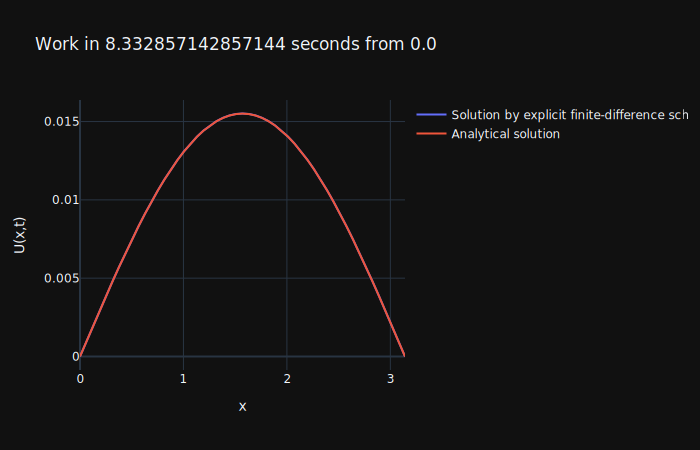

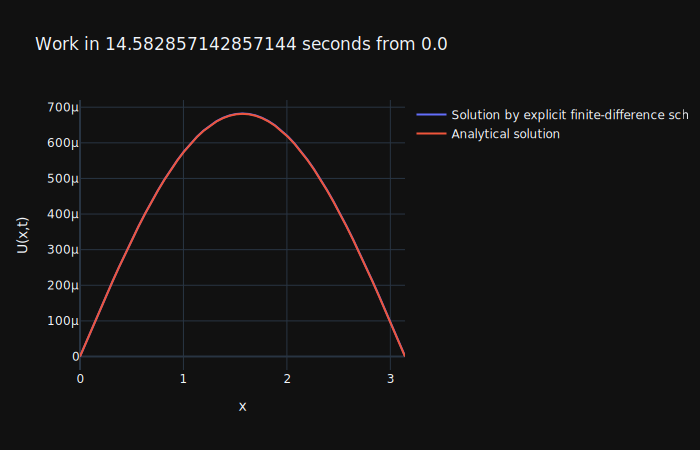

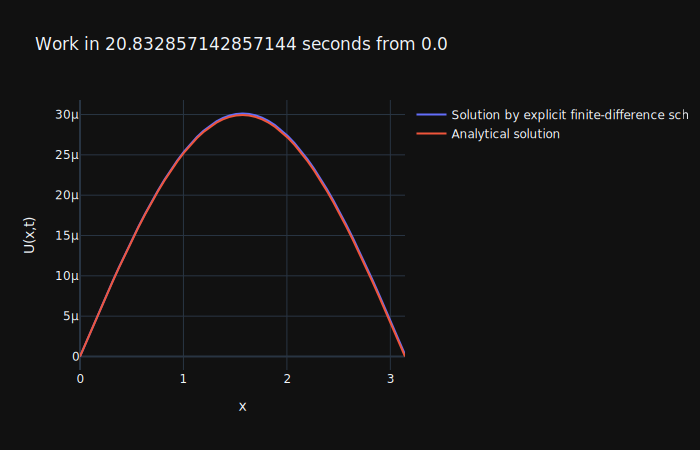

In [ ]:
for i in range(int(len(u_approx[1]) / 6), int(len(u_approx[1])/2), int(len(u_approx[1]) / 8)):
  fig_check = go.Figure()
  fig_check.add_trace(go.Scatter(x = x, y = u_approx[1][i], name = "Solution by explicit finite-difference schema"))
  fig_check.add_trace(go.Scatter(x = x, y = u_a[i], name = "Analytical solution"))
  fig_check.update_layout(title = "Work in " + str(t[i]) + " seconds from " + str(t[0]),
                          xaxis_title = 'x',
                          yaxis_title = 'U(x,t)',
                          template="plotly_dark")
  fig_check.show()
    #save_plot(fig_check)


Построим график погрешности при изменении шага по времени и пространству

  0%|          | 0/3 [00:00<?, ?it/s]

 Attention!!! Courant condition:
sigma > 1/2


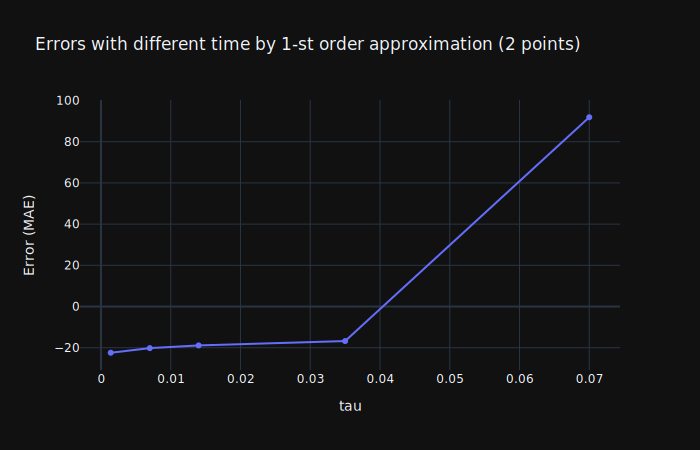

 Attention!!! Courant condition:
sigma > 1/2


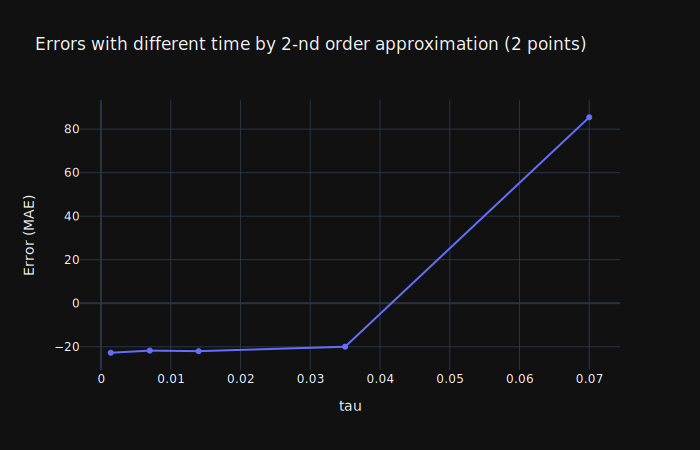

 Attention!!! Courant condition:
sigma > 1/2


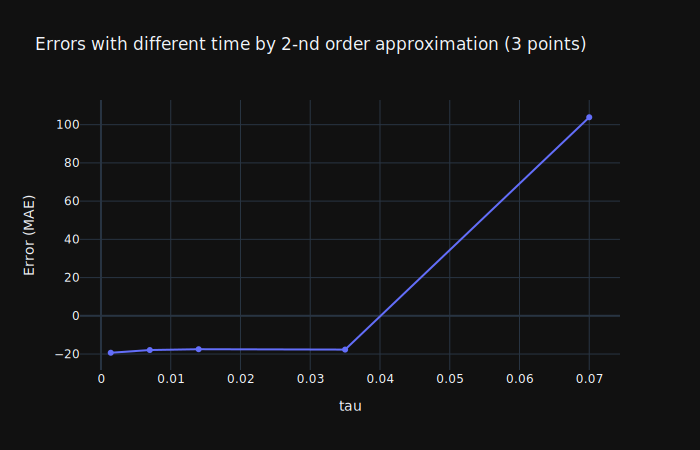

In [ ]:
N_ = 10
T_ = 7

for i in tqdm(range(len(approximations))):
    errors, taus = different_time_error(explicit, N_, T_, approximations[i])
    plot_different_splits(errors, taus, 'time by ' + approximations[i][-1] + ("-st order" if approximations[i][-1] == '1' else "-nd order") +\
                          " approximation (" + approximations[i][0] + " points)", 'tau')

* При увеличении количества разбиений по времени (уменьшении шага по времени) ошибка уменьшается, что может свидетельствовать о сходимости реализованного алгоритма.

* Явно видна неустойчивость схемы при несоблюдении условия Куранта

  0%|          | 0/3 [00:00<?, ?it/s]

 Attention!!! Courant condition:
sigma > 1/2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning:

overflow encountered in double_scalars



 Attention!!! Courant condition:
sigma > 1/2


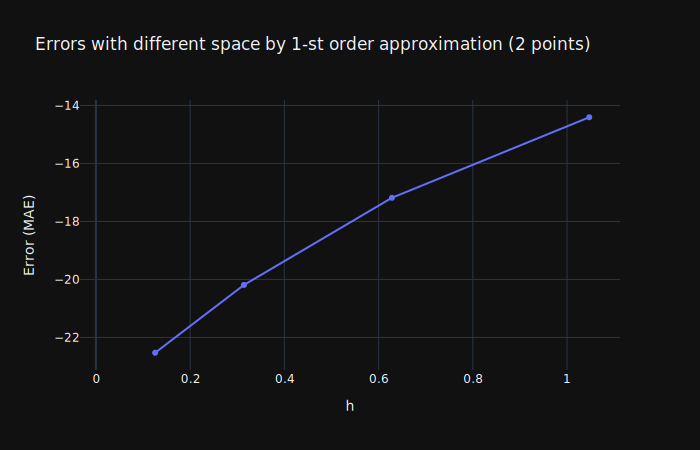

 Attention!!! Courant condition:
sigma > 1/2
 Attention!!! Courant condition:
sigma > 1/2


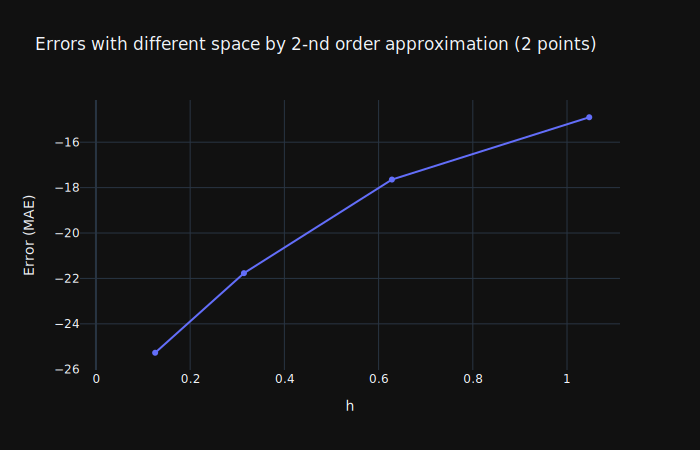

 Attention!!! Courant condition:
sigma > 1/2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

overflow encountered in double_scalars



 Attention!!! Courant condition:
sigma > 1/2


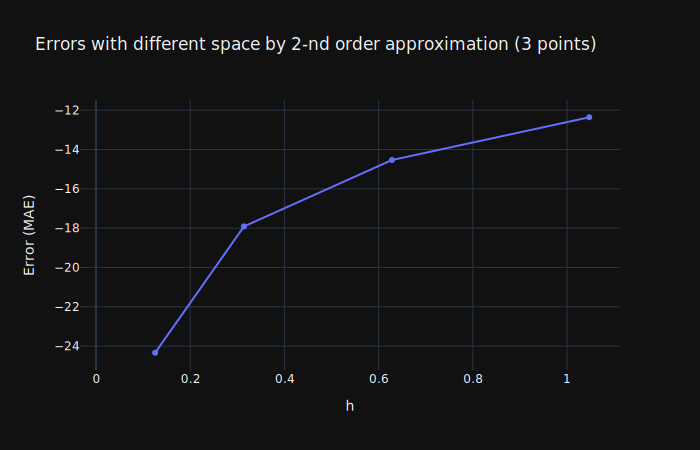

In [ ]:
K_ = 1000
T_ = 7

for i in tqdm(range(len(approximations))):
  errors, hs = different_space_error(explicit, K_, T_, approximations[i])
  plot_different_splits(errors, hs, 'space by ' + approximations[i][-1] + ("-st order" if approximations[i][-1] == '1' else "-nd order") +\
                          " approximation (" + approximations[i][0] + " points)", 'h')

При увеличении разбиений по пространству происходят следующие пируэты:
* Ошибка уменьшается
* Схема становится устойчивой при выполнении условия Куранта

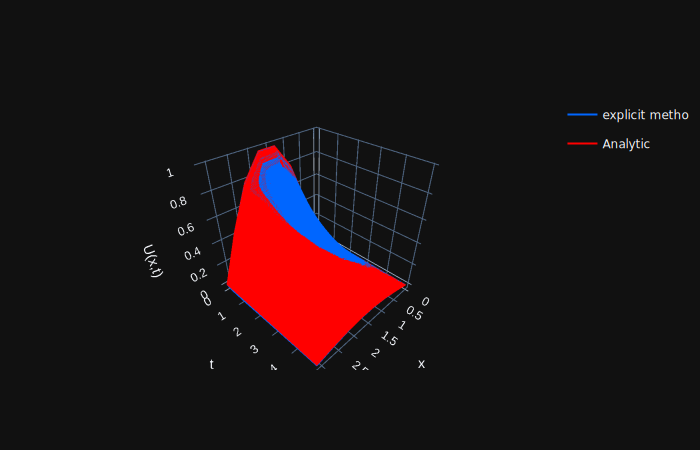

Total error =  0.03705080713046829


In [ ]:
construct_3d_plot(explicit, 'explicit')

## Неявная конечно-разностная схема


In [ ]:
def tma(a,b,c,d,s):
    P = np.zeros(s)
    Q = np.zeros(s)

    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]

    k = s - 1

    for i in range(1, s):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[k] = 0
    Q[k] = (d[k] - a[k] * Q[k - 1]) / (b[k] + a[k] * P[k - 1])

    x = np.zeros(s)
    x[k] = Q[k]

    for i in range(s - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

### Теоретическая часть

Неявная конечно-разностная схема получается путем подстановки аппроксимации дифференциального оператора по пространственной компоненте отношением конечных разностных разностей на верхнем временном слое следующей формы:

$$\frac{\partial^2u}{\partial x^2}\bigg|^{k+1}_j = \frac{u_{j+1}^{k+1} - 2 u_{j}^{k+1} + u_{j-1}^{k+1}}{h^2} + O(h^2)$$

в конкретную задачу. В результате подстановки имеем:

$$\begin{aligned} 
&\frac{u_j^{k+1} - u_j^k}{\tau} = a^2\frac{u_{j+1}^{k+1} - 2u^{k+1}_j + u_{j-1}^{k+1}}{h^2} + O(\tau + h^2), \hspace{0.2cm} j = \overline{1, N-1}, \hspace{0.2cm} k = \overline{0, K-1} \\ 
& u_{0}^{k+1} = \varphi_0(t^{k+1}), \ u_N^{k+1} = \varphi_l(t^{k+1}),\hspace{0.2cm} k = \overline{0, K-1}; \hspace{0.2cm} u^0_j = \psi(x_j), \hspace{0.2cm} j = \overline{0,N}
\end{aligned}$$

Преобразуем первое уравнение к пригодному для решения методом прогонки СЛАУ:

$$a_j \cdot u_{j-1}^{k+1} + b_j\cdot u_j^{k+1} + c_j\cdot u_{j+1}^{k+1} = d_j, \hspace{0.5cm} j = \overline{1,N-1},$$

где $a_j = - \sigma$, $b_j = 1 + 2\sigma$, $c_j = -\sigma$, $d_j = u_j^k$.

Проблемой является зависимой от решения СЛАУ, но зато схема является абсолютно устойчивой.

### Реализация

In [ ]:
def implicit(N, K, T, approx_type = '2d1', a = 1):
    space_step = math.pi/N
    x = np.arange(0, math.pi + space_step - 0.0001, space_step) 
    time_step = T/K
    t = np.arange(0, T + time_step - 0.0001, time_step)
    K = len(t)
    N = len(x)
    U = np.zeros((K, N))
    for j in range(N):
            U[0, j] = np.sin(x[j])
    t = 0
    for k in range(0, K - 1):
        a = np.zeros(N)
        b = np.zeros(N)
        c = np.zeros(N)
        d = np.zeros(N)
        t += tau

        for j in range(1, N - 1):
            a[j] = tau / h**2
            b[j] = -1 - (2 * tau) / h**2
            c[j] = tau / h**2
            d[j] = -U[k][j] - tau * f_1(x[j], t)

        if approx_type == '2d1':
            b[0] = -1 / h
            c[0] = 1 / h
            d[0] = f_2(None, t)

            a[N - 1] = -1 / h
            b[N - 1] = 1 / h
            d[N - 1] = f_3(None, t)
        elif approx_type == '3d2':
            k0 = 1 / (2 * h) / c[1]
            b[0] = (-3 / (h * 2)) + a[1] * k0
            c[0] = 2 / h + b[1] * k0
            d[0] = f_2(None, t) + d[1] * k0

            k1 = -(1 / (h * 2)) / a[N - 2]
            a[N - 1] = (-2 / h) + b[N - 2] * k1
            b[N - 1] = (3 / (h * 2)) + c[N - 2] * k1
            d[N - 1] = f_3(None, t) + d[N - 2] * k1
        elif approx_type == '2d2':
            b[0] = (1 + h**2) / (2 * tau)
            c[0] = 1
            d[0] = -h**2 / (2 * tau) * U[k - 1][0] + f_2(None, t) * h

            a[N - 1] = 1
            b[N - 1] = (1 + h**2) / (2 * tau)
            d[N - 1] = h**2 / (2 * tau) * U[k - 1][N - 1] + f_3(None, t) * h

        u_new = tma(a, b, c, d, N)
        for i in range(N):
            U[k + 1, i] = u_new[i]

    return U

### Исследования

  0%|          | 0/3 [00:00<?, ?it/s]

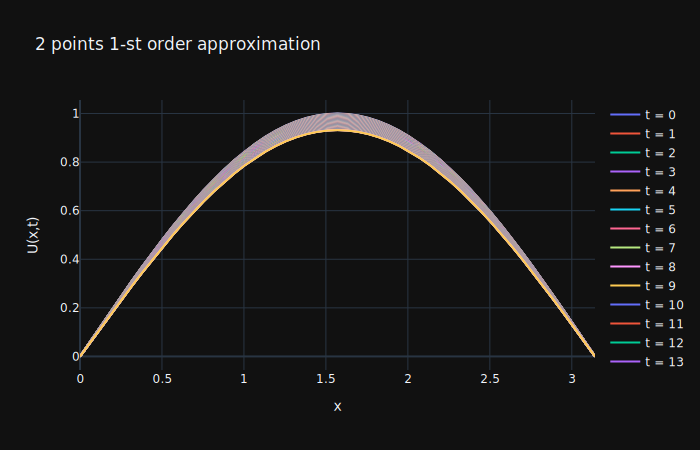

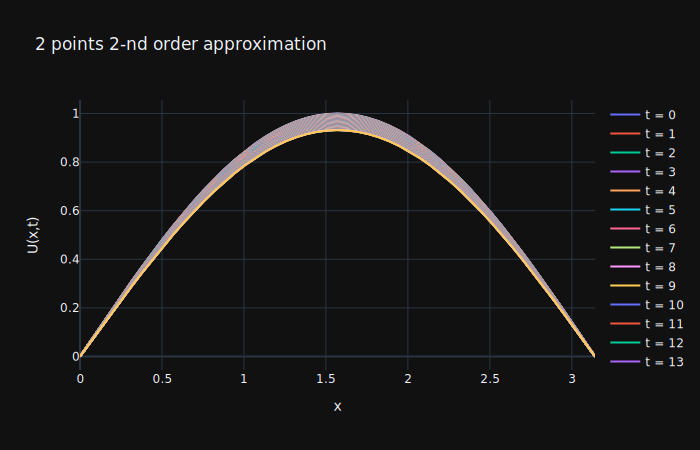

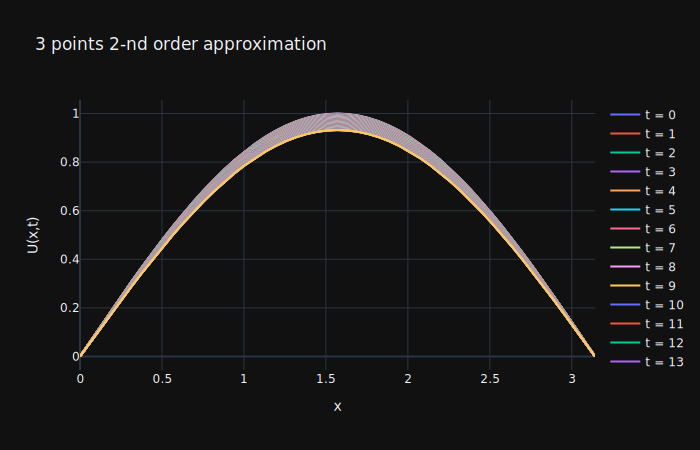

In [ ]:
u_approx = approxes(implicit, N, K, T)
plot_approximations(u_approx, x)

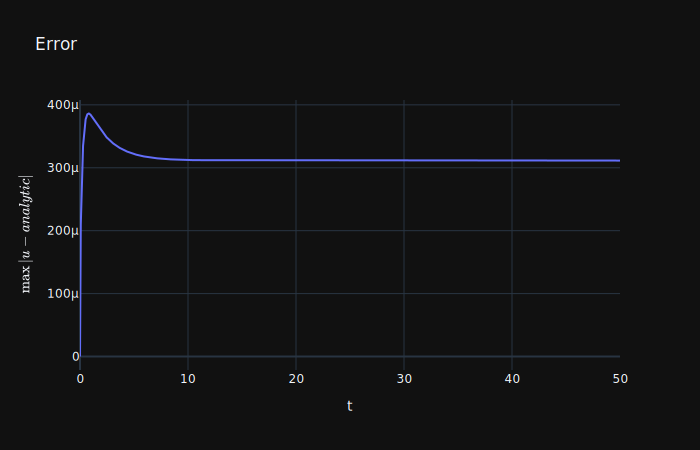

In [ ]:
er = normm(x,t,u_approx[0])
fig_check_tmp = go.Figure()
fig_check_tmp.update_layout(title = "Error",
                            xaxis_title = "t",
                            yaxis_title = r'$\max |u - analytic|$', 
                            template='plotly_dark')
fig_check_tmp.add_trace(go.Scatter(x = t, y = er))
#save_plot(fig_check_tmp)

In [ ]:
[MSE(x, t, u_approx[i]) for i in range(3)]

[2.578240026505253e-14, 1.9297441084351075e-16, 1.282361242477809e-12]

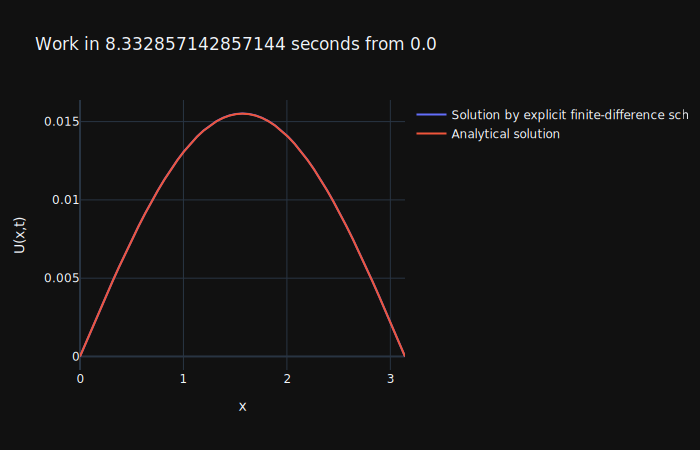

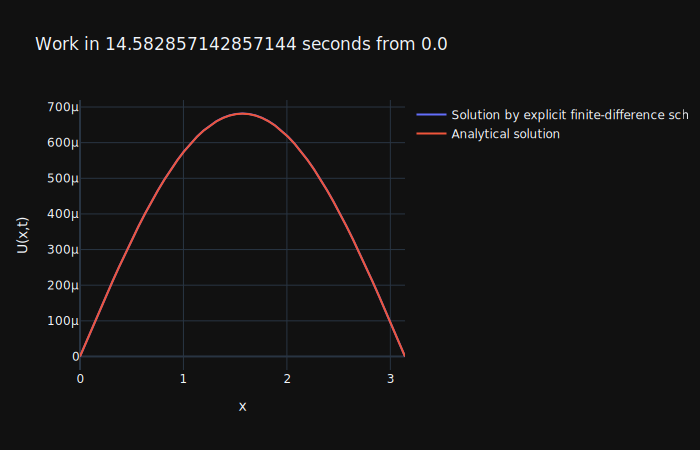

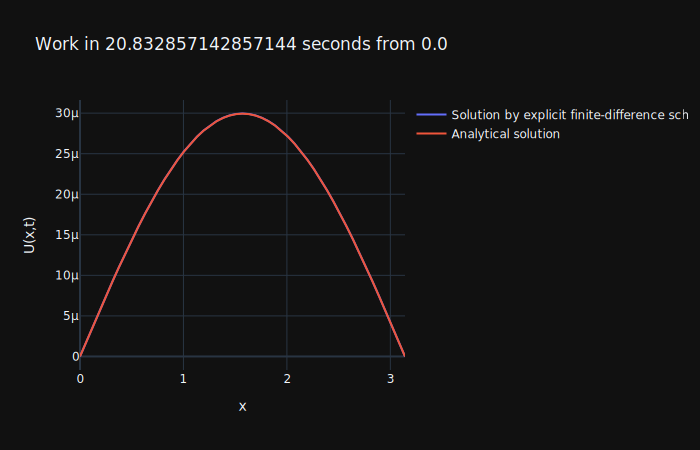

In [ ]:
for i in range(int(len(u_approx[1]) / 6), int(len(u_approx[1])/2), int(len(u_approx[1]) / 8)):
  fig_check = go.Figure()
  fig_check.add_trace(go.Scatter(x = x, y = u_approx[1][i], name = "Solution by explicit finite-difference schema"))
  fig_check.add_trace(go.Scatter(x = x, y = u_a[i], name = "Analytical solution"))
  fig_check.update_layout(title = "Work in " + str(t[i]) + " seconds from " + str(t[0]),
                          xaxis_title = 'x',
                          yaxis_title = 'U(x,t)',
                          template="plotly_dark")
  fig_check.show()
    #save_plot(fig_check)


  0%|          | 0/3 [00:00<?, ?it/s]

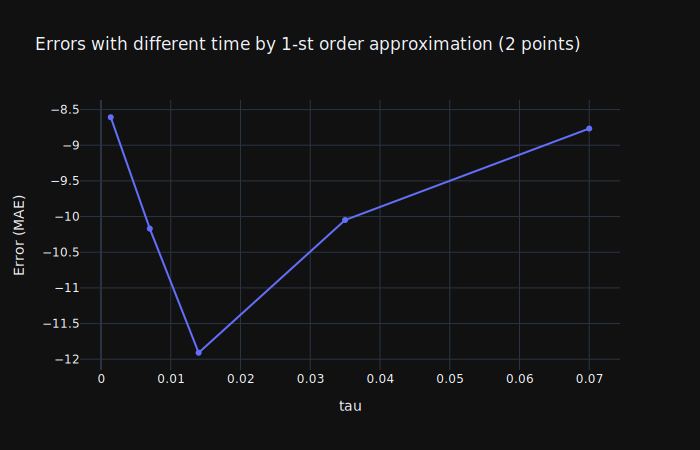

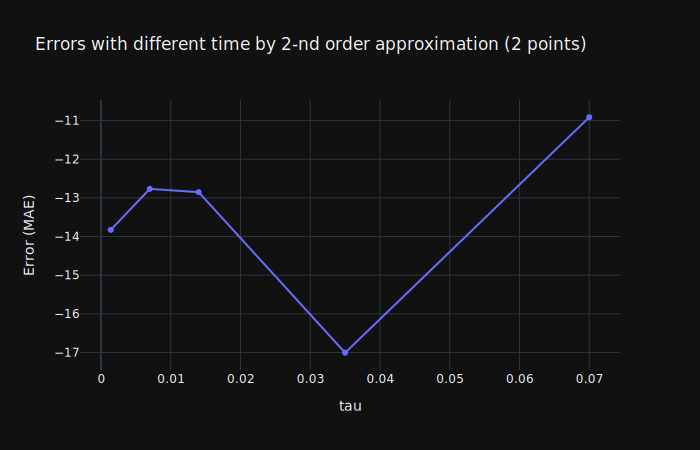

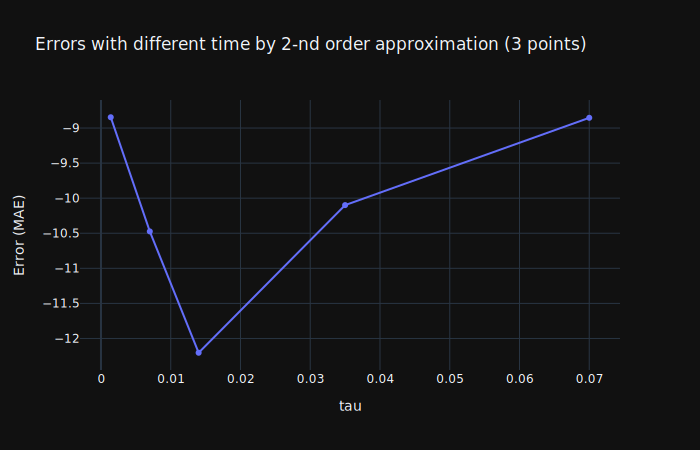

In [ ]:
N_ = 10
T_ = 7

for i in tqdm(range(len(approximations))):
    errors, taus = different_time_error(implicit, N_, T_, approximations[i])
    plot_different_splits(errors, taus, 'time by ' + approximations[i][-1] + ("-st order" if approximations[i][-1] == '1' else "-nd order") +\
                          " approximation (" + approximations[i][0] + " points)", 'tau')

* Схема устойчива
* Тренды схожи с явной схемой, что говорит о сходимости реализации

  0%|          | 0/3 [00:00<?, ?it/s]

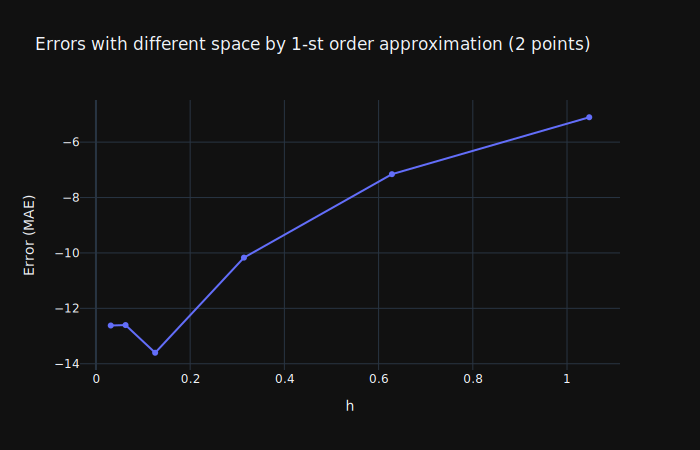

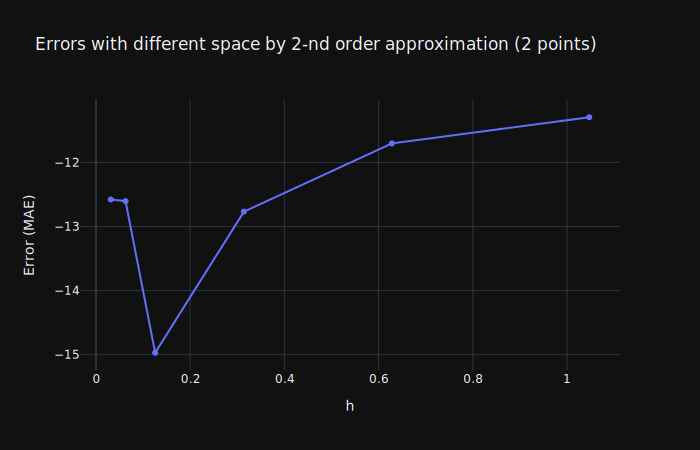

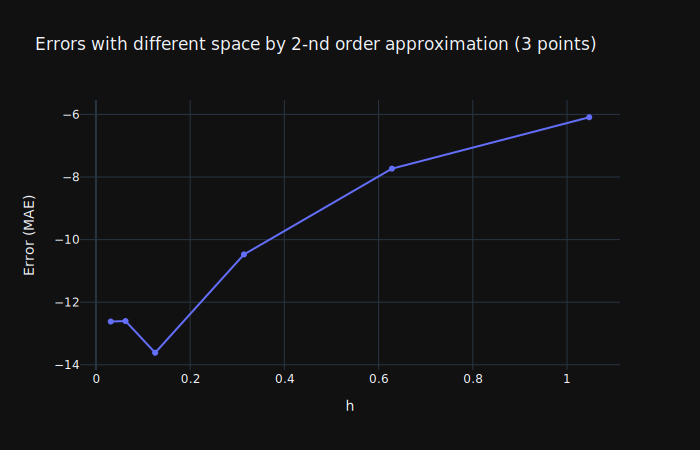

In [ ]:
K_ = 1000
T_ = 7

for i in tqdm(range(len(approximations))):
  errors, hs = different_space_error(implicit, K_, T_, approximations[i])
  plot_different_splits(errors, hs, 'space by ' + approximations[i][-1] + ("-st order" if approximations[i][-1] == '1' else "-nd order") +\
                          " approximation (" + approximations[i][0] + " points)", 'h')

* Похожие тренды
* Схема устойчива

## Схема Кранка-Николсона

### Теоретическая часть



Идея возникла из следующего замечания: на возрастающем участке решение неявной схемы завышается по отношению к точному, а явная наоборот. На убывающем участке ситуация обратная. Рассмотрим неявно-явную схему с весами:

$$\frac{u_j^{k+1}- u_j^k}{\tau} = \theta a^2\frac{u_{j+1}^{k+1} - 2u_j^{k+1} + u_{j-1}^{k+1}}{h^2} + (1-\theta)a^2\frac{u_{j+1}^k - 2u_j^k + u_{j-1}^k}{h^2},$$

где $\theta$ -- вес неявной части конечно-разностной схемы, $1-\theta$ -- вес для явной части, причем $0 \leq \theta \leq 1$. При $\theta = 1$ имеем полностью неявную схему, при $\theta = 0$ -- полностью явную схему. при $\theta = \frac{1}{2}$ -- схему Кранка-Николсона.

### Реализация

In [ ]:
def krank_nicolson(N = 5, K = 70, T = 10, approx_type = '2d2', a = 1.0):

    space_step = math.pi/N
    x = np.arange(0, math.pi + space_step - 0.0001, space_step) 
    time_step = T/K
    t = np.arange(0, T + time_step - 0.0001, time_step)
    K = len(t)
    N = len(x)
    # заполняем решение из начального условия (в нулевой момент времени)
    u = fill(space_step, N, K)

    sigma = 1 / space_step**2
    for k in range(0,K-1):
        a = np.zeros(N)
        b = np.zeros(N)
        c = np.zeros(N)
        d = np.zeros(N)

        for j in range(1, N-1):
            # аппроксимируем уравнение комбинацией явной и неявной разностной схемы
            Rpart = sigma*(u[k][j+1] - 2*u[k][j] + u[k][j-1])/2

            a[j] = sigma/2
            b[j] = - (1/time_step + sigma)
            c[j] = sigma/2
            d[j] = - u[k][j]/time_step - Rpart - f_1(j*space_step,k*time_step)/2 - f_1(j*space_step,k*time_step)/2
       
        if approx_type == '2d1':
            # двухточечная с первым порядком точности
            b[0] = - 1 / space_step
            c[0] = 1 / space_step
            d[0] = f_2(None, (k+1) * time_step)

            a[-1] = - 1 / space_step
            b[-1] = 1 / space_step
            d[-1] = f_3(None, (k+1) * time_step)
        if approx_type == '2d2':
            # двухточечная со вторым порядком точности
            a[0] = - 1 / (2*space_step)
            c[0] = 1 / (2*space_step)
            d[0] = f_2(None, (k+6) * time_step)
            # здесь из 1,2 уравнений - получаем одно, избавляясь от u1
            c[1] = c[1] - a[1]*c[0]/a[0]
            d[1] = d[1] - a[1]*d[0]/a[0]
            a[1] = 0             

            c[-1] =  1 / (2*space_step)
            a[-1] = - 1 / (2*space_step)
            d[-1] = f_3(None, (k+6) * time_step) 
            # здесь из m-1,m-2 уравнений - получаем одно, избавляясь от um-1
            a[-2] = a[-2] - c[-2]*a[-1]/c[-1]
            d[-2] = d[-2] - c[-2]*d[-1]/c[-1]
            c[-2] = 0
        elif approx_type == '3d2':
            # трехточечная со вторым порядком точности
            alpha = 1
            beta = 0
            delta = 0
            gamma = 1
            param_a = 1
            param_b = 0
            b[0] = 2*param_a/space_step + space_step/time_step - (beta/alpha)*(2*param_a - param_b*space_step)
            c[0] = - 2*param_a/space_step
            d[0] = (space_step/time_step)*u[k][0] - f_2(None, (k+1) * time_step) * (2*param_a - param_b*space_step)/alpha

            a[-1] = - 2*param_a/space_step
            b[-1] = 2*param_a/space_step + space_step/time_step + (delta/gamma)*(2*param_a + param_b*space_step)
            d[-1] = (space_step/time_step)*u[k][-1] + f_3(None, (k+1) * time_step) * (2*param_a + param_b*space_step)/gamma

        if approx_type != '2d2':
            # используем прогонку, так как система имеет трехдиагональный тип
            Y = tma(a, b, c, d, N)
        else:
            # иначе - получаем трехдиагональную матрицу из исходной, путем выбора элементов не включая граничные
            a_ = [a[i] for i in range(1,len(a)-1)]
            b_ = [b[i] for i in range(1,len(b)-1)]
            c_ = [c[i] for i in range(1,len(c)-1)]
            d_ = [d[i] for i in range(1,len(d)-1)]
            Y_ = tma(a_, b_, c_, d_, N-2)

            # первый элемент считаем из решения системы по формуле
            Y0 = (d[0] - c[0]*Y_[1])/a[0]

            # аналогично последний элемент
            Ye = (d[-1] - a[-1]*Y_[-2])/c[-1]
            Y = []
            
            # формируем итоговое решение
            Y.append(Y0)
            for y in Y_:
                Y.append(y)
            Y.append(Ye)
        u[k + 1] = Y

    return u

### Исследования

  0%|          | 0/3 [00:00<?, ?it/s]

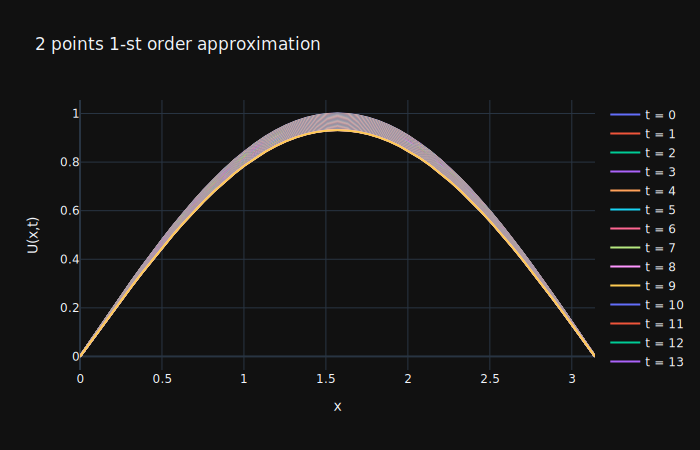

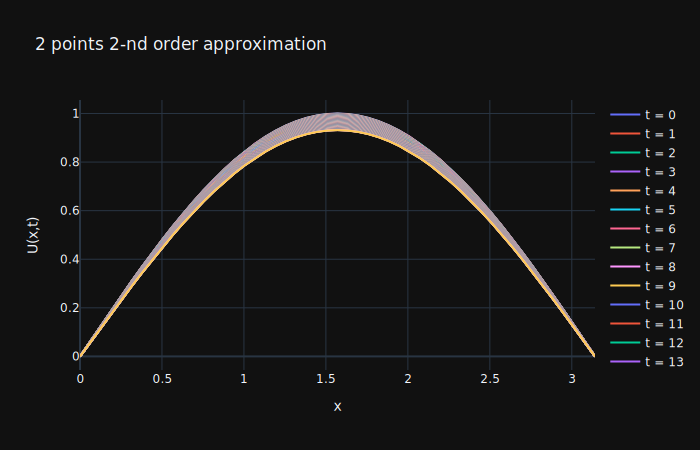

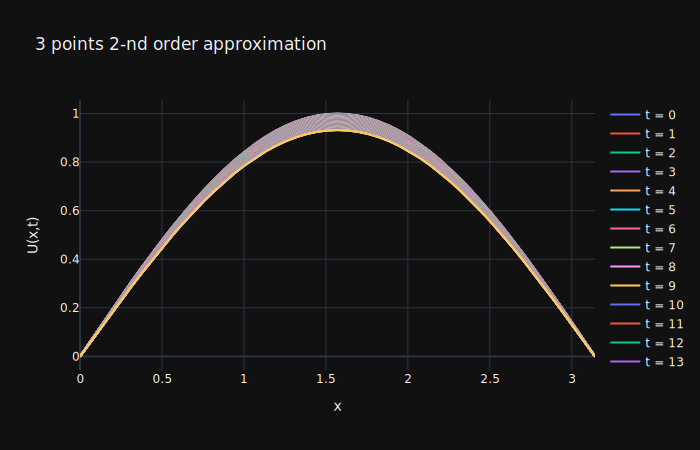

In [ ]:
u_approx_ = approxes(krank_nicolson, N, K, T)
plot_approximations(u_approx_, x)

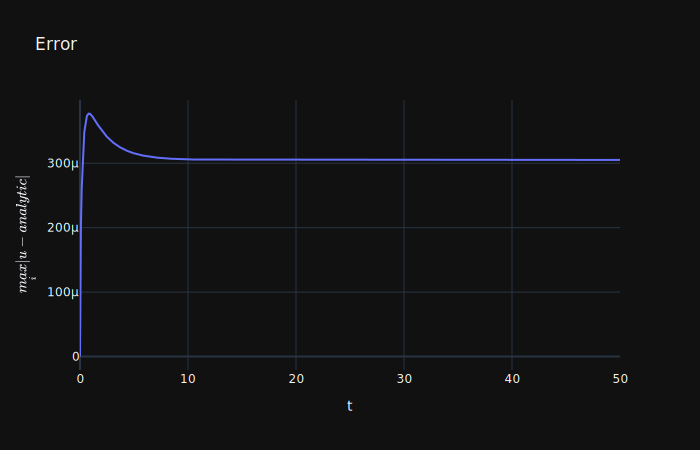

In [ ]:
er = normm(x,t,u_approx_[2])
fig_check_tmp = go.Figure()
fig_check_tmp.add_trace(go.Scatter(x = t, y = er))
fig_check_tmp.update_layout(title = "Error",
                            xaxis_title = "t",
                            yaxis_title = r'$\underset{i}{max} |u - analytic|$', 
                            template='plotly_dark')
#save_plot(fig_check_tmp)
fig_check_tmp.show()

In [ ]:
[MSE(x, t, u_approx[i]) for i in range(3)]

[2.578240026505253e-14, 1.9297441084351075e-16, 1.282361242477809e-12]

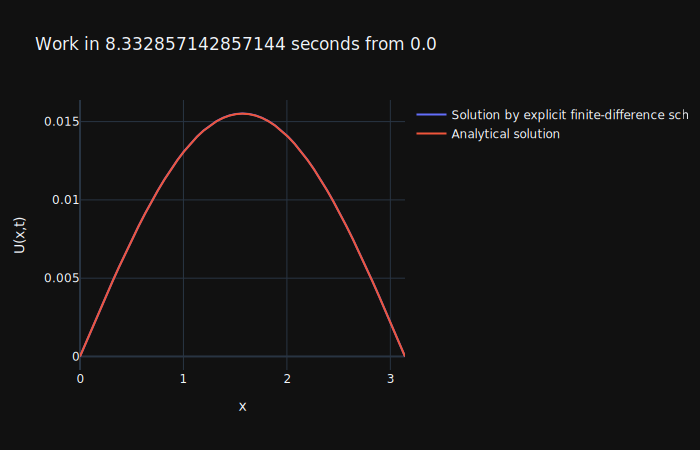

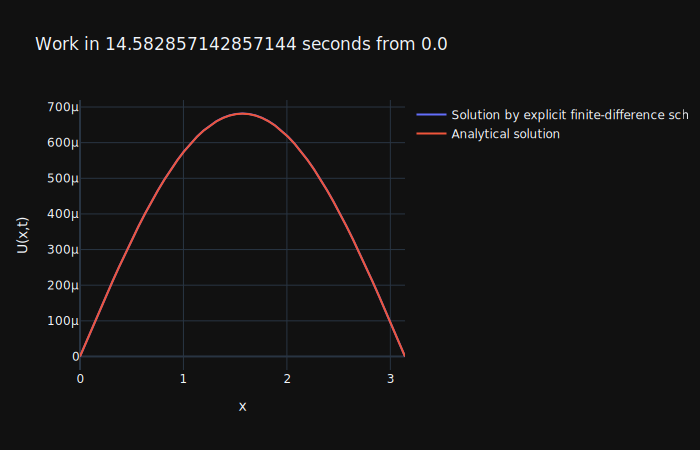

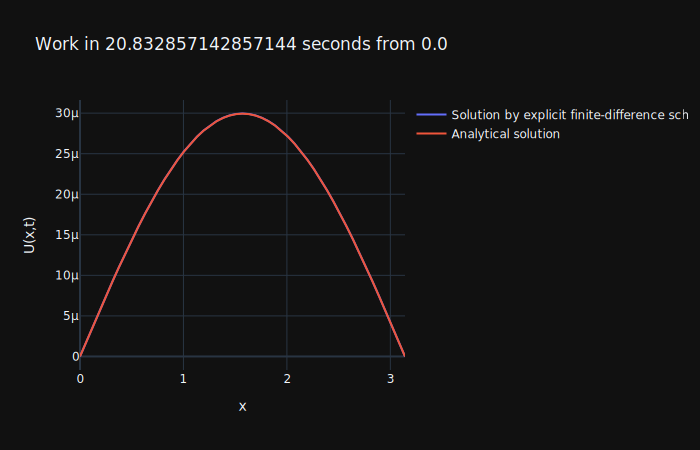

In [ ]:
for i in range(int(len(u_approx[1]) / 6), int(len(u_approx[1])/2), int(len(u_approx[1]) / 8)):
  fig_check = go.Figure()
  fig_check.add_trace(go.Scatter(x = x, y = u_approx[1][i], name = "Solution by explicit finite-difference schema"))
  fig_check.add_trace(go.Scatter(x = x, y = u_a[i], name = "Analytical solution"))
  fig_check.update_layout(title = "Work in " + str(t[i]) + " seconds from " + str(t[0]),
                          xaxis_title = 'x',
                          yaxis_title = 'U(x,t)',
                          template="plotly_dark")
  fig_check.show()
    #save_plot(fig_check)


  0%|          | 0/3 [00:00<?, ?it/s]

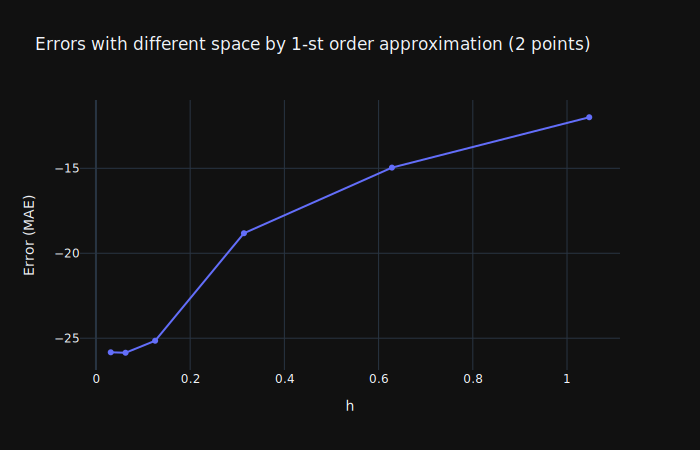

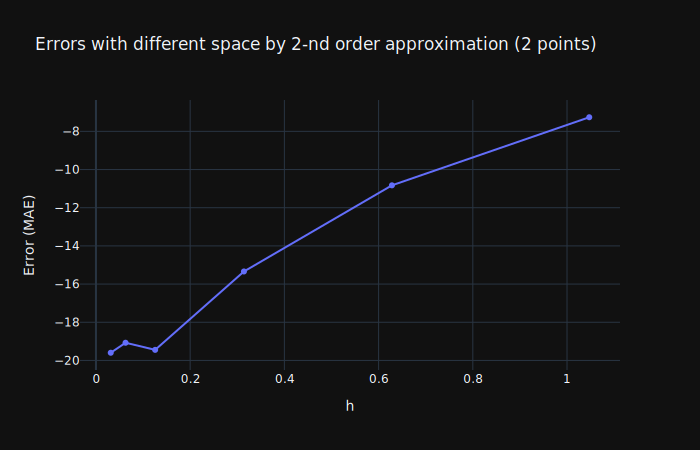

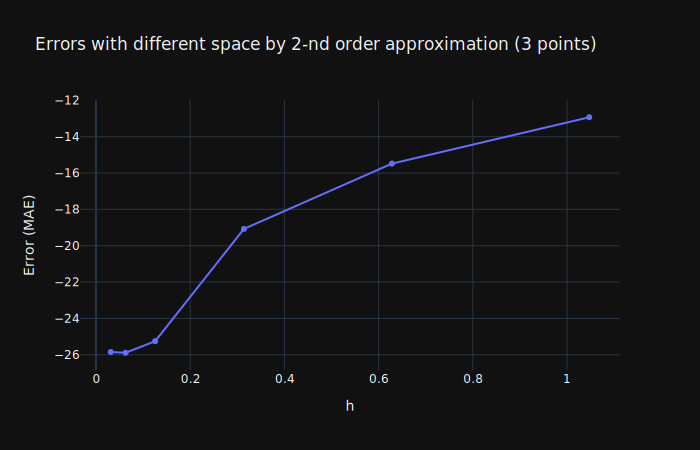

In [ ]:
K_ = 1000
T_ = 7

for i in tqdm(range(len(approximations))):
  errors, hs = different_space_error(krank_nicolson, K_, T_, approximations[i])
  plot_different_splits(errors, hs, 'space by ' + approximations[i][-1] + ("-st order" if approximations[i][-1] == '1' else "-nd order") +\
                          " approximation (" + approximations[i][0] + " points)", 'h')